# 아래는 배터리 클래스 대상임. 다른 클래스를 붙여넣으려면 조금씩 수정 필요함. 지금은 귀찮아서 안할래..

In [13]:
import json
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import os.path as osp
from pycocotools.coco import COCO
import os
import random

In [2]:
with open('/opt/ml/input/data/train_all.json', 'r') as f:
    data = json.load(f)

In [3]:
# 카테고리id, 물체 area, 카테고리id, segmentation

annotations = [[] for _ in range(3272)]
for ann in data['annotations']:
    annotations[ann['image_id']].append([ann['category_id'], ann['area'], ann['category_id'], ann['segmentation']])

# 백그라운드가 대부분인 이미지 구하기

In [10]:
sum_areas = []

for image_id, ann in enumerate(annotations):
    sum_area = 0
    for a in ann:
        sum_area += int(a[1])
    sum_areas.append(sum_area)
    

area_is_zero = []
for i, s in enumerate(sum_areas):
    if s == 0:
        area_is_zero.append(i)

sum_areas = np.array(sum_areas)
background_dominants = sum_areas.argsort()[:150]
background_dominants
    

array([3059,  256, 2564,  248,  263,  175, 2584,  432,  212, 2554, 3187,
        183,  239,  111,  847, 2535,  254,  194, 2555,  106,  264,  842,
        113,  193,  856,  201,  228,  855,  288, 2575,  197,  178,  191,
       2567,  172,  766,  339,  843,  187,  107,  853, 2947,  474, 2568,
         75,  844,   86, 2537,  231,  848,  258,  196,  841, 2585,  115,
       2559, 2533, 3053, 2550, 2577, 1646, 3239,  468,  437, 2576, 2794,
          9,   20, 2939,  434,  245, 3057,  103, 2562, 3253,  846,  109,
       2571,  433,  213, 2548,  377, 3062,  366, 2538,  391, 2989,  556,
         82,  553, 2529,  221,  862,  415,  220, 2925,  858, 2510, 3180,
        186,  791,   72,  223, 3153, 3247,  383, 2588, 3054,   88,  153,
       2597,  238, 3238,  850,   37,  252,  851, 2578, 3207, 2999,  210,
       2592, 3206,   70,  657,  845,   71,  198, 2547,  788,  135,  262,
       2570,  431, 3048,  243, 2660, 2997,  244,  794, 2532, 2923,  242,
       3174, 3225, 3186,  422,  362, 3169, 2561])

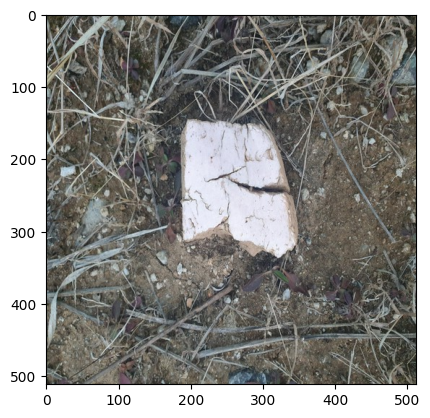

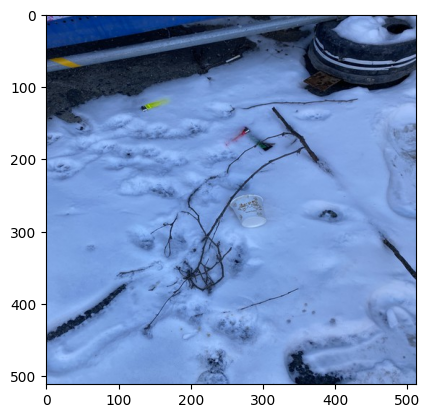

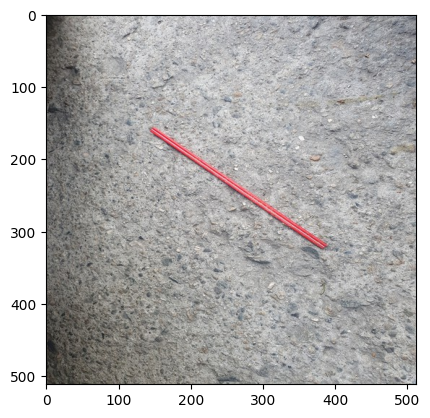

In [11]:
DATA_ROOT = '/opt/ml/input/data'

for b in background_dominants[:5]:
    image_num = b
    img = cv.imread(osp.join(DATA_ROOT, data['images'][image_num]['file_name']))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    plt.imshow(img)
    plt.show()

# 배터리가 포함된 이미지 구하기

In [12]:
categories = dict()
for d in data['categories']:
    categories[d['id']] = d['name']
    
categories

{1: 'General trash',
 2: 'Paper',
 3: 'Paper pack',
 4: 'Metal',
 5: 'Glass',
 6: 'Plastic',
 7: 'Styrofoam',
 8: 'Plastic bag',
 9: 'Battery',
 10: 'Clothing'}

배터리가 포함된 이미지의 수 : 114
[28, 47, 52, 101, 102, 122, 123, 133, 134, 138, 139, 140, 144, 146, 154, 156, 199, 233, 240, 260, 266, 355, 365, 480, 504, 509, 574, 592, 607, 768, 816, 820, 824, 827, 883, 1034, 1056, 1100, 1137, 1181, 1275, 1315, 1350, 1352, 1512, 1529, 1550, 1561, 1573, 1679, 1699, 1707, 1710, 1779, 1839, 1860, 1869, 1969, 1988, 2014, 2040, 2096, 2121, 2132, 2219, 2225, 2227, 2284, 2333, 2398, 2448, 2466, 2469, 2476, 2540, 2543, 2545, 2553, 2580, 2582, 2637, 2640, 2641, 2676, 2678, 2686, 2700, 2747, 2748, 2749, 2804, 2812, 2817, 2818, 2853, 2855, 2864, 2866, 3005, 3013, 3017, 3041, 3056, 3094, 3095, 3107, 3109, 3110, 3118, 3156, 3201, 3221, 3254, 3263]


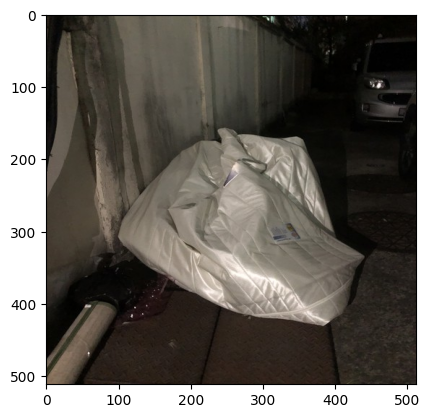

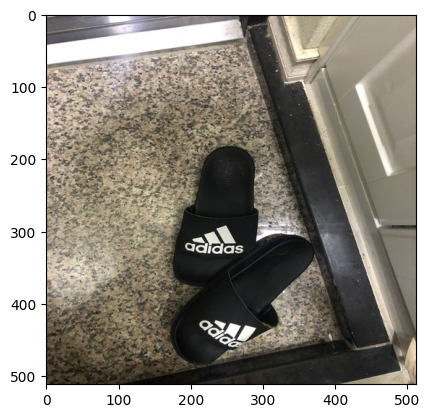

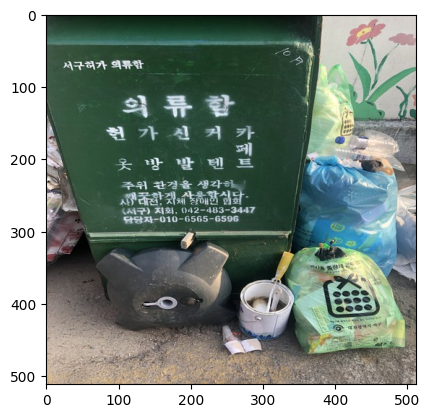

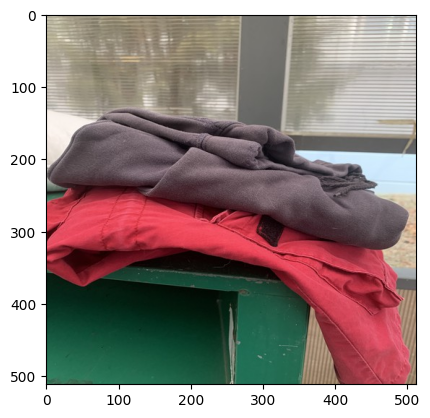

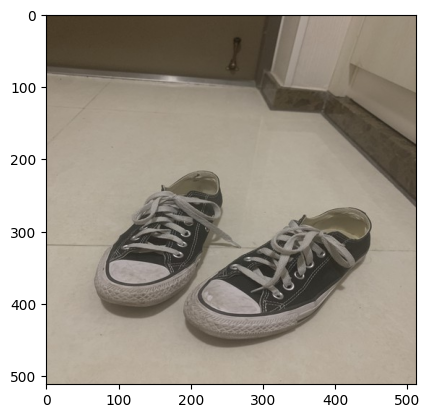

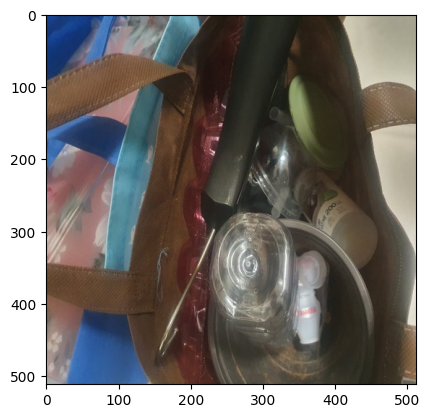

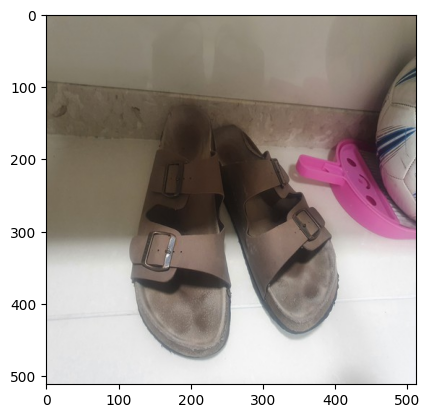

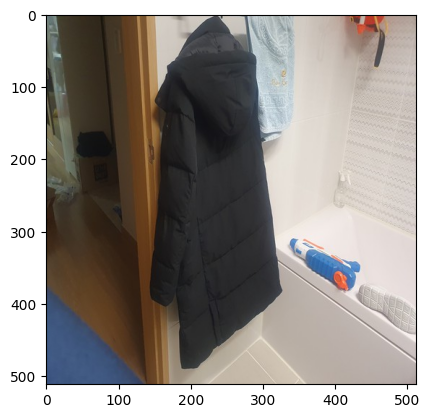

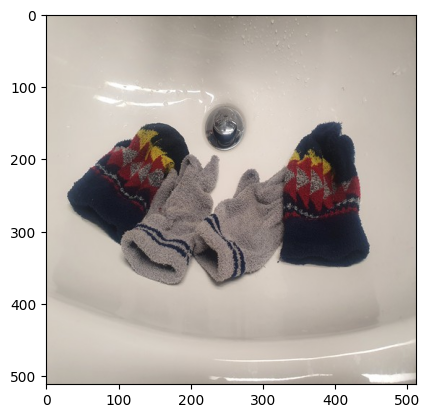

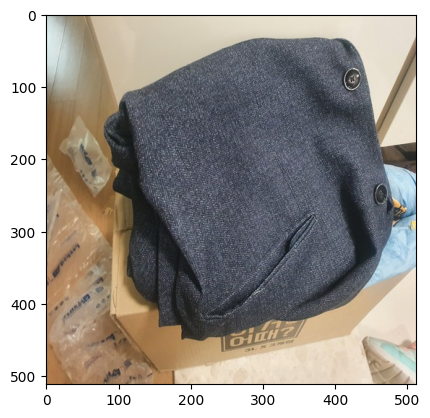

In [85]:
counter = 0
battery_images = []
clothing_images = []

for i, ann in enumerate(annotations):
    flag = False
    for a in ann:
        if a[2] == 9:
            flag = True
    if flag:
        counter += 1
        battery_images.append(i)
        
print('배터리가 포함된 이미지의 수 :', counter)
print(battery_images)

for b in battery_images[:10]:
    image_num = b
    img = cv.imread(osp.join(DATA_ROOT, data['images'][image_num]['file_name']))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    plt.imshow(img)
    plt.show()

# 배터리 마스크 샘플링 데모

(109, 151, 3)


(89, 187, 3)


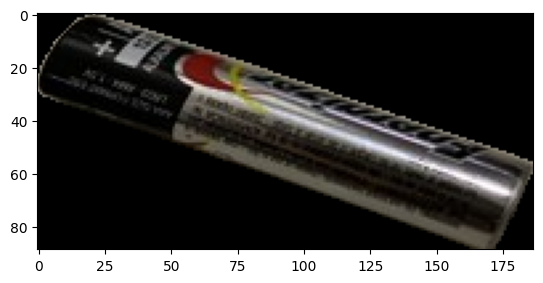

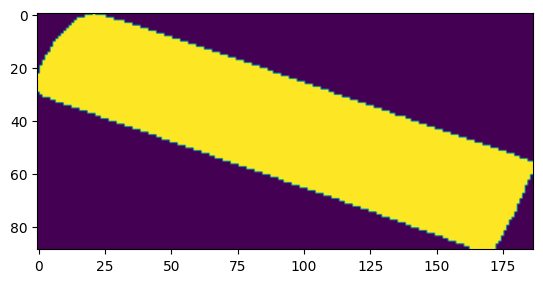

(80, 157, 3)


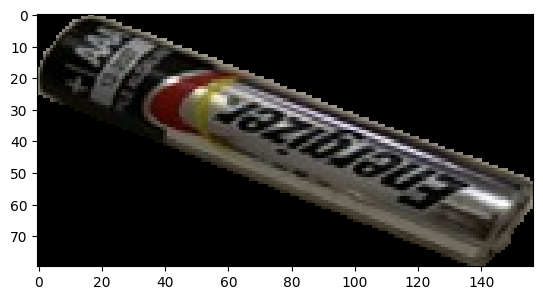

(102, 107, 3)


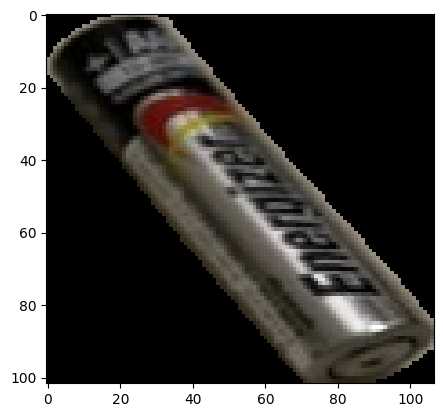

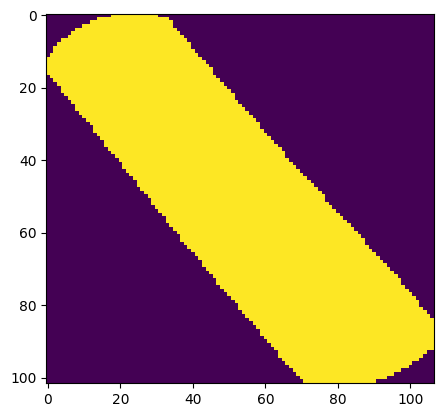

(60, 175, 3)


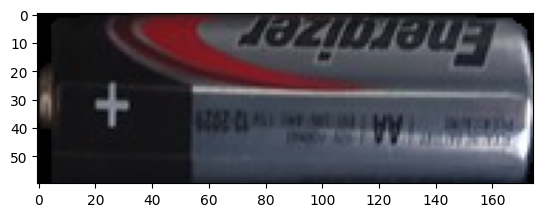

(65, 143, 3)


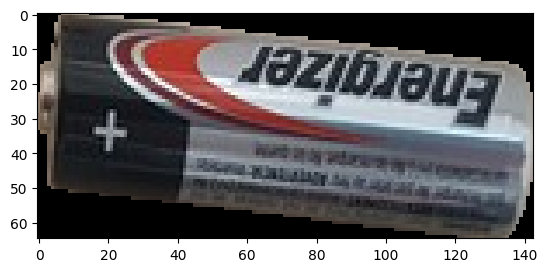

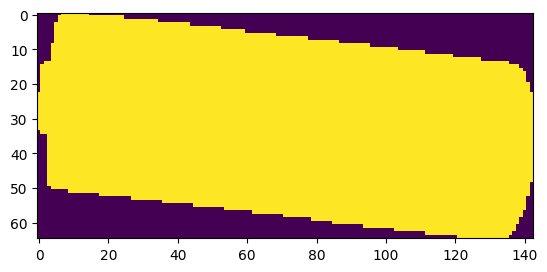

(60, 147, 3)


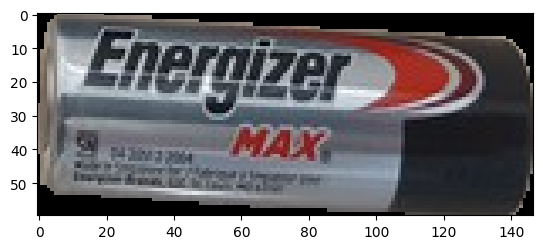

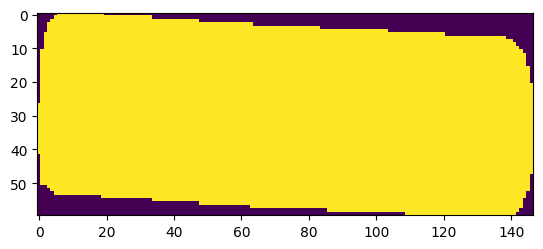

(137, 61, 3)


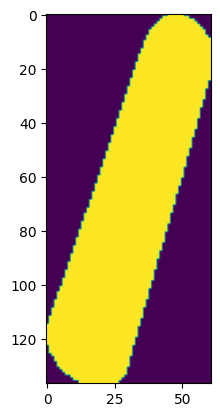

(164, 67, 3)


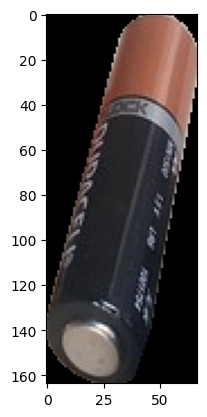

(185, 88, 3)


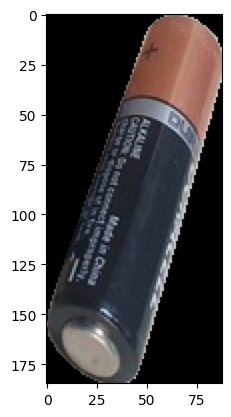

In [94]:
samples = []
battery_images = [105, 115, 153, 166, 168, 266, 758, 816, 933, 2118, 2548, 3111, 3157, 3165, 3172]

for i, ori in enumerate(battery_images):
    original_image = cv.imread(osp.join(DATA_ROOT, data['images'][ori]['file_name']))
    original_image = cv.cvtColor(original_image, cv.COLOR_BGR2RGB)

    for ann in annotations[battery_images[i]]:
        if ann[2] != 9:
            continue
        foreground = np.zeros(shape=(512,512), dtype=np.uint8)
        
        
        mask = ann[3][0]
        mask = np.array(mask, dtype='int').reshape((-1, 2))
        # print(mask)
        minX = np.min(mask[:, 0])
        maxX = np.max(mask[:, 0])
        minY = np.min(mask[:, 1])
        maxY = np.max(mask[:, 1])
        
        cropped = original_image[minY:maxY, minX:maxX]
        foreground = cv.fillPoly(foreground, [mask], color=[255]).copy()
        
        sample = cv.bitwise_and(original_image, original_image, mask=foreground)
        sample = sample[minY:maxY, minX:maxX]
        foreground = foreground[minY:maxY, minX:maxX]
        samples.append([sample, foreground])
    
for s in samples[:10]:
    print(s[0].shape)
    plt.imshow(s[0])
    plt.show()
    plt.imshow(s[1])
    plt.show()
    
    

# 기존 마스크 가져오기

In [52]:
coco = COCO('/opt/ml/input/data/train_all.json')

loading annotations into memory...
Done (t=5.02s)
creating index...
index created!


In [75]:
def get_original_mask(image_id):
    category_names = [
        'Backgroud',
        'General trash',
        'Paper',
        'Paper pack',
        'Metal',
        'Glass',
        'Plastic',
        'Styrofoam',
        'Plastic bag',
        'Battery',
        'Clothing'
        ]

    image_infos = coco.loadImgs(image_id)[0]
    ann_ids = coco.getAnnIds(imgIds=image_infos['id'])
    anns = coco.loadAnns(ann_ids)

    masks = np.zeros((image_infos["height"], image_infos["width"]))

    anns = sorted(anns, key=lambda idx : idx['area'], reverse=True)
    for i in range(len(anns)):
        className = categories[anns[i]['category_id']]
        pixel_value = category_names.index(className)
        masks[coco.annToMask(anns[i]) == 1] = pixel_value
    masks = masks.astype(np.int8)

    return masks

In [97]:
os.makedirs('./images', exist_ok = True)
os.makedirs('./annotations', exist_ok = True)

for idx, b in enumerate(background_dominants[:]):
    print(b)
    
    original_mask = get_original_mask(data['images'][b]['id'])
    img = cv.imread(osp.join(DATA_ROOT, data['images'][b]['file_name']))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    print(original_mask.shape)
    
    annot = np.zeros(shape=(512,512,3), dtype=np.uint8)
    
    
    
    how_many = np.random.randint(1, 5)
    print('paste {} images'.format(how_many))
    sample_nums = random.sample(range(len(samples)), how_many)
    for i in range(how_many):
        scale = np.random.random_sample() + 0.5
        sample = samples[sample_nums[i]][0]
        mask = samples[sample_nums[i]][1]
        
        xlen = int(sample.shape[0] * scale)
        ylen = int(sample.shape[1] * scale)
        
        try:
            sample = cv.resize(sample, dsize=(ylen, xlen))
            mask = cv.resize(mask, dsize=(ylen, xlen))
        except:
            continue
        
        xcor = np.random.randint(0, 512-xlen)
        ycor = np.random.randint(0, 512-ylen)
        
        foreground = np.zeros(shape=(512,512,3), dtype=int)
        foreground_mask = np.zeros(shape=(512,512), dtype=int)
        
        foreground[xcor:xcor+xlen, ycor:ycor+ylen] = sample
        foreground_mask[xcor:xcor+xlen, ycor:ycor+ylen] = mask
        
        img[foreground_mask > 0] = foreground[foreground_mask > 0]
        original_mask[foreground_mask > 0] = 9
        
    cv.imwrite('./images/{}.png'.format(str(idx).zfill(4)), img)
    cv.imwrite('./annotations/{}.png'.format(str(idx).zfill(4)), original_mask)
    

3059
(512, 512)
paste 1 images
256
(512, 512)
paste 3 images
2564
(512, 512)
paste 4 images
248
(512, 512)
paste 3 images
263
(512, 512)
paste 2 images
175
(512, 512)
paste 1 images
2584
(512, 512)
paste 4 images
432
(512, 512)
paste 2 images
212
(512, 512)
paste 2 images
2554
(512, 512)
paste 4 images
3187
(512, 512)
paste 2 images
183
(512, 512)
paste 2 images
239
(512, 512)
paste 1 images
111
(512, 512)
paste 2 images
847
(512, 512)
paste 1 images
2535
(512, 512)
paste 4 images
254
(512, 512)
paste 3 images
194
(512, 512)
paste 2 images
2555
(512, 512)
paste 1 images
106
(512, 512)
paste 2 images
264
(512, 512)
paste 3 images
842
(512, 512)
paste 3 images
113
(512, 512)
paste 1 images
193
(512, 512)
paste 4 images
856
(512, 512)
paste 3 images
201
(512, 512)
paste 4 images
228
(512, 512)
paste 1 images
855
(512, 512)
paste 2 images
288
(512, 512)
paste 1 images
2575
(512, 512)
paste 4 images
197
(512, 512)
paste 3 images
178
(512, 512)
paste 3 images
191
(512, 512)
paste 3 images
25